<a href="https://colab.research.google.com/github/r-iradukunda/AgriBot_Summative/blob/main/AgriBot_summative_%5BRuth%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgriCulture_ChatBot (AGRI_BOT)

This project is an AI-powered agriculture assistant that instantly answers farming-related questions. Using a T5 transformer model trained on 22,615 question-answer pairs, it provides accurate, practical solutions to common farming problems—from pest control to irrigation methods. Designed to be a 24/7 digital farming expert, it helps farmers make informed decisions quickly and efficiently, bridging the gap between agricultural knowledge and real-world application through simple, conversational AI

In [ ]:
# ===============================
# Install Requirements (Dependincies)
# ===============================
!pip install --upgrade transformers datasets -q

In [ ]:
# ===============================
# Import Libraries
# ===============================
import pandas as pd
import re
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# ===============================
# Load & Clean Dataset
# ===============================
dataset = load_dataset("KisanVaani/agriculture-qa-english-only")
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answers'],
        num_rows: 22615
    })
})

In [ ]:
dataset.shape

{'train': (22615, 2)}

In [ ]:
print("Few rows for sample dataset: \n")
print(dataset['train'][0])

Few rows for sample dataset: 

{'question': 'why is crop rotation important in farming?', 'answers': 'This helps to prevent soil erosion and depletion, and can also help to control pests and diseases'}


In [ ]:
df = dataset["train"].to_pandas()
df.head()

,question,answers
0,why is crop rotation important in farming?,This helps to prevent soil erosion and depleti...
1,What farming practice helps prevent soil erosion?,Crop Rotation
2,what is crop rotation,Crop rotation is the practice of growing a ser...
3,what are the different methods of irrigation?,"surface irrigation, drip irrigation, and sprin..."
4,why is soil health vital?,Soil health is critical to crop growth and pro...


In [ ]:
# Finding and Remove Missing Values
print("Checking for missing values:")
for col in ['question', 'answers']:
    missing_count = 0
    for i, val in enumerate(df[col]):
        if pd.isna(val) or str(val).strip() == '':
            missing_count += 1
    print(f"{col}: {missing_count} missing values")
df.dropna(subset=['question', 'answers'], inplace=True)


Checking for missing values:
question: 0 missing values
answers: 0 missing values


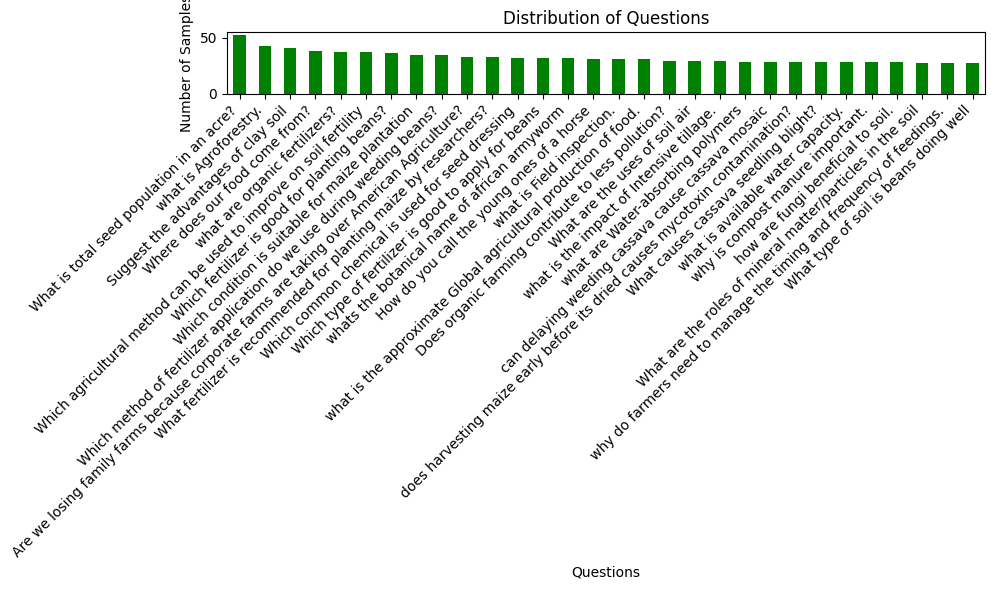

In [ ]:
from matplotlib import pyplot as plt

# Visualizing the most frequent asked questions in the dataset.
questions_counts = df['question'].value_counts().head(30)

# Plot the bar chart
plt.figure(figsize=(10, 6))
questions_counts.plot(kind='bar', color='g')
plt.title('Distribution of Questions')
plt.xlabel('Questions')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# Prepare Dataset for T5
# ===============================
# defining function for normalization
def normalize_input(text):
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\?\.,!]', '', text)
    return text

df['question'] = df['question'].apply(normalize_input)
df['answers'] = df['answers'].apply(normalize_input)



In [ ]:
# dataset splitting
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
# Convert pandas DataFrames back to Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Create a DatasetDict from the train and validation datasets
split_dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})


print("Train Dataset Shape:", train_df.shape)
print("Validation Dataset Shape:", val_df.shape)

train_df.head()

Train Dataset Shape: (18092, 2)
Validation Dataset Shape: (4523, 2)


,question,answers
0,what causes plant diseases?,"variety of pathogens, including fungi, bacteri..."
1,what are organic fertilizers?,"organic fertilizers, which are made from natur..."
2,name the virus that causes cassava brown steak...,cassava brown streak virus cbsv and ugandan ca...
3,why are farmers not encouraged to collect soil...,these areas may have localized nutrient concen...
4,what is milled maize?,milled maize also known as maize flour is made...


In [ ]:
# ===============================
# Tokenization
# ===============================
# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Preprocessing function
def preprocess_func(examples):
    # Use the actual column names 'question' and 'answers'
    # examples is now a dictionary of lists
    inputs = ["question: " + q for q in examples["question"]]
    targets = examples["answers"]

    # Ensure both inputs and targets are strings (should be covered by list comprehension, but defensive check)
    inputs = [str(inp) for inp in inputs]
    targets = [str(tar) for tar in targets]

    model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Apply preprocessing to the split_dataset
# Remove the original columns 'question' and 'answers' after preprocessing
tokenized_dataset = split_dataset.map(preprocess_func, remove_columns=["question", "answers"], batched=True)

# Set the format for training
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

Map:   0%|          | 0/18092 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/4523 [00:00<?, ? examples/s]

In [ ]:
# ===============================
# Training Arguments
# ===============================
training_args = TrainingArguments(
    output_dir="./agri-t5-model",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=6,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir='./logs',
    logging_steps=10,
    push_to_hub=False,
    report_to=[]
)

# ===============================
# Fine-Tuning
# ===============================
model = T5ForConditionalGeneration.from_pretrained("t5-small")

trainer = Trainer(
    model=model,
    args=training_args,
    # Use the correct split datasets from tokenized_dataset
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Evaluate before training
baseline_metrics = trainer.evaluate()
baseline_loss = baseline_metrics['eval_loss']
print(f"Initial (baseline) Loss: {baseline_loss:.4f}")

# Train the model
trainer.train()

# Evaluate after training
tuned_metrics = trainer.evaluate()
tuned_loss = tuned_metrics['eval_loss']
print(f"Tuned Loss: {tuned_loss:.4f}")
print(f"Loss Improvement: {((baseline_loss - tuned_loss)/baseline_loss) * 100:.2f}%")


/tmp/ipython-input-30-1966664627.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Initial (baseline) Loss: 15.9909


Epoch,Training Loss,Validation Loss,Model Preparation Time
1,0.529400,0.331982,0.004400
2,0.300500,0.164695,0.004400
3,0.172500,0.109022,0.004400
4,0.235200,0.090209,0.004400
5,0.133800,0.082745,0.004400
6,0.079900,0.080611,0.004400


Tuned Loss: 0.0806
Loss Improvement: 99.50%


In [ ]:
# Save model
model.save_pretrained("./agri-t5-model")
tokenizer.save_pretrained("./agri-t5-model")

('./agri-t5-model/tokenizer_config.json',
 './agri-t5-model/special_tokens_map.json',
 './agri-t5-model/spiece.model',
 './agri-t5-model/added_tokens.json')

In [ ]:
# Reload the model
model = T5ForConditionalGeneration.from_pretrained("./agri-t5-model")
tokenizer = T5Tokenizer.from_pretrained("./agri-t5-model")

def get_agri_response(question):
    input_text = "question: " + question.strip().lower()
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    outputs = model.generate(
        input_ids,
        max_length=192,           # Allow longer answers
        num_beams=5,              # More thorough beam search
        no_repeat_ngram_size=2,   # Avoid repetition
        early_stopping=False      # Let the generation finish naturally
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test Samples
questions = [
    "which countries do we find african armyworm?",
    "how do you space maize when planting.",
    "what is the required humidity for cassava growth."
]


# Run test
for q in questions:
    print(f"\nQuestion: {q}")
    print(f"Bot Answer: {get_agri_response(q)}")


Question: which countries do we find african armyworm?
Bot Answer: tanzania, rwanda and south africa

Question: how do you space maize when planting.
Bot Answer: when spacing maize it may solely depend on the variety and soil fertility. however, as a general guideline, you can consult local agricultural extension services or plant specialists for specific spacing recommendations tailored to your specific location and location requirements.

Question: what is the required humidity for cassava growth.
Bot Answer: ranging from 70 to 90


In [ ]:
# ===============================
# Gradio Interface
# ===============================

import gradio as gr

# Define chatbot function
def get_agri_response(question):
    input_text = "question: " + question
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    output_ids = model.generate(input_ids, max_length=128, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer

# Creating interface
interface = gr.Interface(
    fn=get_agri_response,
    inputs=gr.Textbox(lines=2, placeholder="Ask a farming-related question...", label="Your Question"),
    outputs=gr.Textbox(label="AgriBot's Answer"),
    title="AgriBot: Agriculture Question Answering Chatbot",
    description="Ask me anything about farming practices, crop health, pest control, or agricultural techniques.",
    theme="default"
)

# Launch the interface
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ac3f0a28275a5e1c47.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
